In [ ]:
!pip install camel-tools
!pip install qalsadi

In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from joblib import load
from nltk.stem.isri import ISRIStemmer
from collections import Counter
import matplotlib.pyplot as plt
import qalsadi.lemmatizer

# Import CAMeL Tools
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_alef_ar, normalize_teh_marbuta_ar, normalize_alef_maksura_ar

In [ ]:
import nltk
nltk.download('all')

# Dataset

In [ ]:
# Load dataset and stop words
from google.colab import files

# Upload the new dataset
uploaded = files.upload()
df = pd.read_excel(list(uploaded.keys())[0])

# Upload stop words list
uploaded = files.upload()
stop_words_list = load(list(uploaded.keys())[0])


Saving imbalanced_dataset.xlsx to imbalanced_dataset.xlsx


Saving libyan-stopwords-list.joblib to libyan-stopwords-list.joblib


Dataset Statistics

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22762 entries, 0 to 22761
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       22762 non-null  int64 
 1   Sentiment        22762 non-null  object
 2   Sentence         22762 non-null  object
 3   Sentence Length  22762 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 711.4+ KB
None

First Few Rows:
   Unnamed: 0 Sentiment                          Sentence  Sentence Length
0           0  positive         ضحكت ضحك قلبي و رفرف طاير                6
1           1  positive       اللي شوفها نحلف اتقول بشاير                5
2           2  positive                ضحكت الله ايعينها                 3
3           3  positive         روحي و كلي صرت دوم سجينها                6
4           4  positive  و على اخدودها أنا شفت نقرة زينها                7

Missing Values in Each Column:
Unnamed: 0         0
Sentiment          0
Sentence  

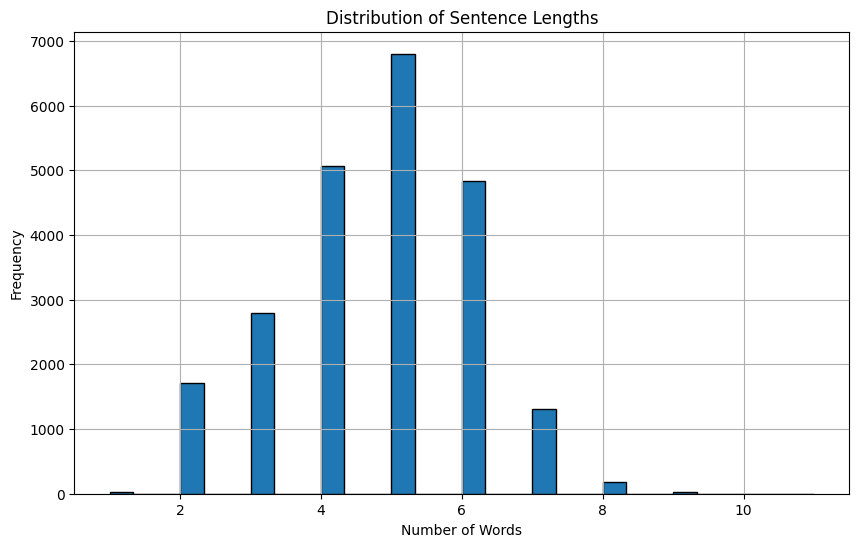

10 Most Common Words:
[('و', 9912), ('ما', 2827), ('في', 2190), ('يا', 1611), ('من', 1542), ('لا', 1326), ('اللي', 1273), ('كيف', 538), ('كل', 523), ('الله', 456)]


In [ ]:
# Drop unnecessary columns
columns_to_drop = ['Metaphor', 'keywords', 'Source domain', 'Target domain', 'Hidden target domain']
df.drop(columns=columns_to_drop, inplace=True, axis=1)
df.drop_duplicates(keep='first', inplace=True)

print("Dataset Info:")
print(df.info())

print("\nFirst Few Rows:")
print(df.head())

print("\nMissing Values in Each Column:")
print(df.isnull().sum())

if 'Sentiment' in df.columns:
    print("\nClass Distribution:")
    print(df['Sentiment'].value_counts())

df['Sentence Length'] = df['Sentence'].apply(lambda x: len(x.split()))

print("Sentence Length Statistics:")
print(df['Sentence Length'].describe())

plt.figure(figsize=(10, 6))
df['Sentence Length'].hist(bins=30, edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

all_words = [word for sentence in df['Sentence'] for word in sentence.split()]
word_counts = Counter(all_words)

print("10 Most Common Words:")
print(word_counts.most_common(10))

# Preprocessing Step

In [ ]:
isri_stemmer = ISRIStemmer()
lemmer = qalsadi.lemmatizer.Lemmatizer()

def preprocessing(sentence, use_stemming=True, use_lemmatization=True, remove_stopwords=True):
    tokens = simple_word_tokenize(sentence)

    tokens = [dediac_ar(token) for token in tokens]

    tokens = [normalize_alef_ar(token) for token in tokens]
    tokens = [normalize_teh_marbuta_ar(token) for token in tokens]
    tokens = [normalize_alef_maksura_ar(token) for token in tokens]

    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words_list or word == 'قلبي']

    if use_stemming:
        tokens = [isri_stemmer.stem(token) for token in tokens]

    if use_lemmatization:
        tokens = [lemmer.lemmatize(token) for token in tokens]

    return tokens


In [ ]:
def preprocess_dataset(df, config):
    preprocessed_sentences = []
    for sentence in df['Sentence']:
        tokens = preprocessing(
            sentence,
            use_stemming=config.get("stemming", True),
            use_lemmatization=config.get("lemmatization", True),
            remove_stopwords=config.get("remove_stopwords", True)
        )
        preprocessed_sentences.append(' '.join(tokens))
    return preprocessed_sentences

# Experiments Configuration

In [ ]:
experiments = {
    "Stemming with Stopwords Removal": {"stemming": True, "remove_stopwords": True, "lemmatization": False},
    "Stemming without Stopwords Removal": {"stemming": True, "remove_stopwords": False, "lemmatization": False},
    "Lemmatization with Stopwords Removal": {"stemming": False, "remove_stopwords": True, "lemmatization": True},
    "Lemmatization without Stopwords Removal": {"stemming": False, "remove_stopwords": False, "lemmatization": True},
    "Stemming and Lemmatization with Stopwords Removal": {"stemming": True, "remove_stopwords": True, "lemmatization": True},
    "Stemming and Lemmatization without Stopwords Removal": {"stemming": True, "remove_stopwords": False, "lemmatization": True},
}

ngrams = {
    'Unigrams': (1, 1),
    'Bigrams': (2, 2),
    'Trigrams': (3, 3),
    'Unigrams & Bigrams': (1, 2),
    'Unigrams & Trigrams': (1, 3),
    'Bigrams & Trigrams': (2, 3),
}


# Initialize the Classifiers

In [ ]:
svm = SVC(random_state=42)
nb = MultinomialNB()
lr = LogisticRegression(random_state=42, max_iter=1000)

classifiers = {
    'SVM': svm,
    'Naive Bayes': nb,
    'Logistic Regression': lr
}

# Experiments and Results

In [ ]:
def optimize_ngram_for_classifier(classifiers, df, experiments, ngrams):
    best_ngrams = {}

    for exp_name, config in experiments.items():
        print(f"Optimizing N-grams for Experiment: {exp_name}")
        preprocessed_texts = preprocess_dataset(df, config)
        y = df['Sentiment']

        for clf_name, clf in classifiers.items():
            print(f"Classifier: {clf_name}")
            best_accuracy = 0
            best_ngram = None

            for ngram_name, ngram_range in ngrams.items():
                tfidf = TfidfVectorizer(ngram_range=ngram_range)
                X = tfidf.fit_transform(preprocessed_texts)

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                print(f"N-gram: {ngram_name} | Accuracy: {accuracy:.2f}")

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_ngram = ngram_range

            best_ngrams[(exp_name, clf_name)] = best_ngram
            print(f"Best N-gram for {clf_name} in {exp_name}: {best_ngram} with Accuracy: {best_accuracy:.2f}")

    return best_ngrams

classifiers = {
    'SVM': SVC(kernel='linear', random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}
best_ngrams = optimize_ngram_for_classifier(classifiers, df, experiments, ngrams)


Optimizing N-grams for Experiment: Stemming with Stopwords Removal
Classifier: SVM
N-gram: Unigrams | Accuracy: 0.70
N-gram: Bigrams | Accuracy: 0.63
N-gram: Trigrams | Accuracy: 0.60
N-gram: Unigrams & Bigrams | Accuracy: 0.71
N-gram: Unigrams & Trigrams | Accuracy: 0.71
N-gram: Bigrams & Trigrams | Accuracy: 0.63
Best N-gram for SVM in Stemming with Stopwords Removal: (1, 3) with Accuracy: 0.71
Classifier: Naive Bayes
N-gram: Unigrams | Accuracy: 0.69
N-gram: Bigrams | Accuracy: 0.63
N-gram: Trigrams | Accuracy: 0.60
N-gram: Unigrams & Bigrams | Accuracy: 0.70
N-gram: Unigrams & Trigrams | Accuracy: 0.69
N-gram: Bigrams & Trigrams | Accuracy: 0.63
Best N-gram for Naive Bayes in Stemming with Stopwords Removal: (1, 2) with Accuracy: 0.70
Classifier: Logistic Regression
N-gram: Unigrams | Accuracy: 0.70
N-gram: Bigrams | Accuracy: 0.62
N-gram: Trigrams | Accuracy: 0.60
N-gram: Unigrams & Bigrams | Accuracy: 0.70
N-gram: Unigrams & Trigrams | Accuracy: 0.70
N-gram: Bigrams & Trigrams | 

In [ ]:
final_results = []

for exp_name, config in experiments.items():
    print(f"Training for Experiment: {exp_name}")
    preprocessed_texts = preprocess_dataset(df, config)
    y = df['Sentiment']

    for clf_name, clf in classifiers.items():
        best_ngram = best_ngrams[(exp_name, clf_name)]
        tfidf = TfidfVectorizer(ngram_range=best_ngram)
        X = tfidf.fit_transform(preprocessed_texts)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        final_results.append({
            "Experiment": exp_name,
            "Classifier": clf_name,
            "N-gram": best_ngram,
            "Accuracy": accuracy
        })

        print(f"Classifier: {clf_name} | Accuracy: {accuracy:.2f}")

results_df = pd.DataFrame(final_results)
print(results_df)


Training for Experiment: Stemming with Stopwords Removal
Classifier: SVM | Accuracy: 0.71
Classifier: Naive Bayes | Accuracy: 0.70
Classifier: Logistic Regression | Accuracy: 0.70
Training for Experiment: Stemming without Stopwords Removal
Classifier: SVM | Accuracy: 0.74
Classifier: Naive Bayes | Accuracy: 0.72
Classifier: Logistic Regression | Accuracy: 0.72
Training for Experiment: Lemmatization with Stopwords Removal
Classifier: SVM | Accuracy: 0.72
Classifier: Naive Bayes | Accuracy: 0.71
Classifier: Logistic Regression | Accuracy: 0.71
Training for Experiment: Lemmatization without Stopwords Removal
Classifier: SVM | Accuracy: 0.75
Classifier: Naive Bayes | Accuracy: 0.72
Classifier: Logistic Regression | Accuracy: 0.72
Training for Experiment: Stemming and Lemmatization with Stopwords Removal
Classifier: SVM | Accuracy: 0.71
Classifier: Naive Bayes | Accuracy: 0.70
Classifier: Logistic Regression | Accuracy: 0.70
Training for Experiment: Stemming and Lemmatization without Stopwo

In [ ]:
# Retrieve feature importance
import numpy as np

if hasattr(clf, 'coef_'):
    feature_names = tfidf.get_feature_names_out()
    coef = clf.coef_
    top_features = np.argsort(coef[0])[-10:]  # Top 10 positive features

    print("Top Features:")
    for idx in top_features:
        print(f"{feature_names[idx]}: {coef[0][idx]:.4f}")

Top Features:
لا أدار: 4.7227
فزع: 4.8179
سمح: 4.9604
سعد: 4.9618
زها: 5.0507
وجع بعد: 5.2292
صف: 5.4265
زين: 5.4395
جود: 5.8063
كرم: 6.4809
